## Visual QC notebook
This notebook is designed to be used in a visual QC check of regridded CMIP6 data. Regridded files are counted, and a percentage of the files (here 10%) are randomly selected for QC. Using only the output file names, we will:

- locate the original CMIP6 source data
- plot source data alongside regridded data to compare visually

#### How to use with `prefect` via `papermill`:
This notebook should be run as the final step of the prefect regridding flow. The output will be saved as a new notebook in the QC directory created during the flow. To accomplish this, create a task in the prefect flow that will execute this notebook from the command line using `papermill`, e.g.:

```papermill path/to/repo/regridding/visual_qc.ipynb path/to/qc/output/output.ipynb -r output_directory "/path/to/output/dir" -r cmip6_directory "/path/to/cmip6/dir"```

The first argument is this notebook's location, which can be constructed using the `{output_directory}` parameter of the flow run (ie, the notebook's location within the downloaded repo directory). The second argument is the desired notebook output location, which can also be constructed using the `{output_directory}` parameter of the flow run. The remaining arguments are raw strings (denoted by `-r`) of the working and input directories used in the flow run.

Papermill parameter cell:

In [1]:
# this cell is tagged "parameters" and contains default parameter values for this notebook
# any parameters injected by papermill during the prefect flow will be written into a new cell directly beneath this one
# and will override the values in this cell
output_directory = '/beegfs/CMIP6/arctic-cmip6/regrid/'
cmip6_directory = '/beegfs/CMIP6/arctic-cmip6/CMIP6/'

Import packages

In [2]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import random
from pandas.errors import OutOfBoundsDatetime
from pathlib import Path
from config import *
from regrid import open_and_crop_dataset, prod_lat_slice

#### Setup
Define data sources and parameters for QC.

In [3]:
# set cmip6_dir
cmip6_dir = Path(cmip6_directory)
# set regrid_dir and list all *.nc files
regrid_dir = Path(output_directory)
regrid_fps = list(regrid_dir.glob("**/*.nc"))

#set min and max number of files to QC
min_qc = 20
max_qc = 75

#pick a percentage of the regridded files for visual QC, and count those files
pct = 10
pct_count = round(len(regrid_fps) * (pct/100))

#use all files if less than minimum are available
#use max number of random files if percentage exceeds maximum
#or just use percentage of random files
if (len(regrid_fps) <= min_qc):
    qc_files = regrid_fps
elif (pct_count >= max_qc):
    qc_files = random.sample(regrid_fps, max_qc)
else:
    qc_files = random.sample(regrid_fps, pct_count)

#### Create functions
Here we will build some helper functions to aid us perform a qualitative assessment of the regridding. Using just the regridded file name and the main CMIP6 source directory, we will reconstruct the source file path and by plot a comparison of source files and regridded files.

In [4]:
def get_matching_time_filepath(fps, test_date):
    """Find a file from a given list of raw CMIP6 filepaths that conatins the test date within the timespan in the filename."""
    matching_fps = []
    for fp in fps:
        start_str, end_str = fp.name.split(".nc")[0].split("_")[-1].split("-")
        start_str = f"{start_str}01" if len(start_str) == 6 else start_str
        # end date should be constructed as the end of month for monthly data
        #  (and should always be December??)
        end_str = f"{end_str}31" if len(end_str) == 6 else end_str
        format_str = "%Y%m%d"
        try:
            start_dt = pd.to_datetime(start_str, format=format_str)
            # it should be OK if end date is
            end_dt = pd.to_datetime(end_str, format=format_str)
        except OutOfBoundsDatetime:
            # we should not be regridding files with time values that cause this (2300 etc)
            continue

        if start_dt <= test_date < end_dt:
            matching_fps.append(fp)

    # there should only be one
    assert len(matching_fps) == 1

    return matching_fps[0]


def generate_cmip6_filepath_from_regrid_filename(fn):
    """Get the path to the original CMIP6 filename from a regridded file name.

    Because the original CMIP6 filenames were split up during the processing, 
    this method finds the original filename based on matching all possible attributes, 
    then testing for inclusion of regrid file start date within the date range formed by the CMIP6 file timespan.
    """
    var_id, freq, model, scenario, _, timespan = fn.split(".nc")[0].split("_")
    institution = model_inst_lu[model]
    experiment_id = "ScenarioMIP" if scenario in prod_scenarios else "CMIP"
    # Construct the original CMIP6 filepath from the filename.
    # Need to use glob because of the "grid type" filename attribute that we do not have a lookup for.
    var_dir = cmip6_dir.joinpath(f"{experiment_id}/{institution}/{model}/{scenario}")
    glob_str = f"*/{freq}/{var_id}/*/*/{var_id}_{freq}_{model}_{scenario}_*.nc"
    candidate_fps = list(var_dir.glob(glob_str))

    start_str = timespan.split("-")[0]
    format_str = "%Y%m" if len(start_str) == 6 else "%Y%m%d"
    start_dt = pd.to_datetime(start_str, format=format_str)
    cmip6_fp = get_matching_time_filepath(candidate_fps, start_dt)

    return cmip6_fp


def plot_comparison(regrid_fp):
    """For a given regridded file, find the source file and plot side by side.
    """
    src_fp = generate_cmip6_filepath_from_regrid_filename(regrid_fp.name)
    src_ds = open_and_crop_dataset(src_fp, lat_slice=prod_lat_slice)
    regrid_ds = xr.open_dataset(regrid_fp)
    lat_slice = slice(55, 75)
    lon_slice_src = slice(200, 240)
    lon_slice_regrid = slice(-160, -120)
    time_val = regrid_ds.time.values[0]
    var_id = src_ds.attrs["variable_id"]

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(
        f"Variable: {var_id}     Model: {src_ds.attrs['source_id']}     Scenario: {src_ds.attrs['experiment_id']}"
    )

    # now, there are multiple possible time formats for the source dataset.
    # convert the chosen time value to that matching format for subsetting.
    sel_method = None
    if isinstance(src_ds.time.values[0], cftime._cftime.Datetime360Day):
        src_hour = src_ds.time.dt.hour[0]
        src_time = cftime.Datetime360Day(
            year=time_val.year, month=time_val.month, day=time_val.day, hour=src_hour
        )
    elif isinstance(
        src_ds.time.values[0], pd._libs.tslibs.timestamps.Timestamp
    ) or isinstance(src_ds.time.values[0], np.datetime64):
        src_hour = src_ds.time.dt.hour[0]
        src_time = pd.to_datetime(
            f"{time_val.year}-{time_val.month}-{time_val.day}T{src_hour}:00:00"
        )
    else:
        if time_val not in src_ds.time.values:
            src_hour = src_ds.time.dt.hour[0]
            src_time = cftime.DatetimeNoLeap(
                year=time_val.year,
                month=time_val.month,
                day=time_val.day,
                hour=src_hour,
            )
        else:
            src_time = time_val
    if src_time not in src_ds.time.values:
        if src_ds.attrs["frequency"] == "mon":
            # too much variability in day used (e.g. 14, 15, 16), "nearest" method for selection will work
            sel_method = "nearest"
        else:
            print(src_time)
            print(src_ds.time)
            assert False

    #get a vmin and vmax from src dataset to use for both plots, if a map
    vmin = src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).values.min()
    vmax = src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).values.max()

    try: #maps
        src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).plot(ax=axes[0], vmin=vmin, vmax=vmax)
        axes[0].set_title(f"Source dataset (timestamp: {src_time})")
        regrid_ds[var_id].sel(time=time_val).sel(lat=lat_slice, lon=lon_slice_regrid).plot(ax=axes[1], vmin=vmin, vmax=vmax)
        axes[1].set_title(f"Regridded dataset (timestamp: {time_val})")
        axes[1].set_xlabel("longitude [standard]")
        plt.show()

    except: #histograms
        src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).plot(ax=axes[0])
        axes[0].set_title(f"Source dataset (timestamp: {src_time})")
        regrid_ds[var_id].sel(time=time_val).sel(lat=lat_slice, lon=lon_slice_regrid).plot(ax=axes[1])
        axes[1].set_title(f"Regridded dataset (timestamp: {time_val})")
        plt.show()


From our previous random selection of regridded files to QC, plot comparisons in a spatial domain that includes Alaska and western Canada.

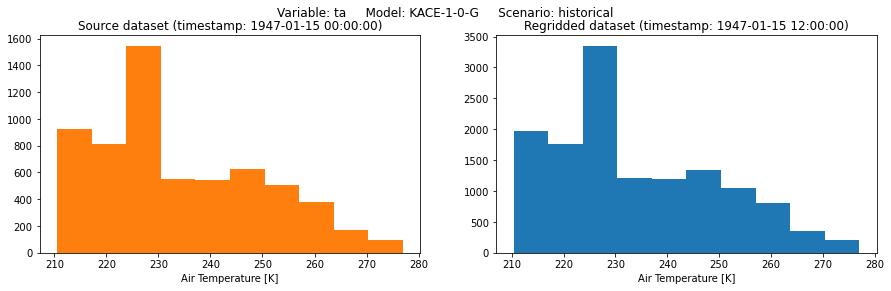

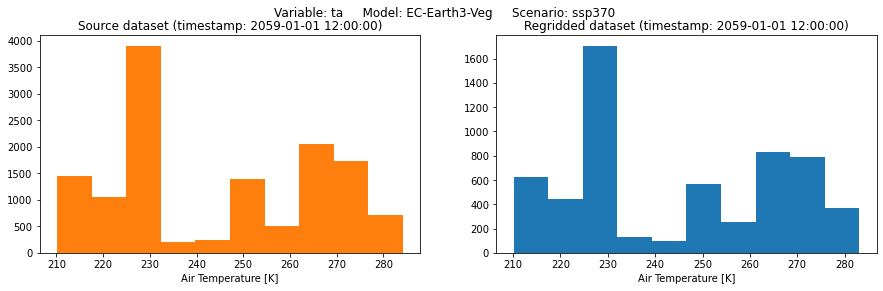

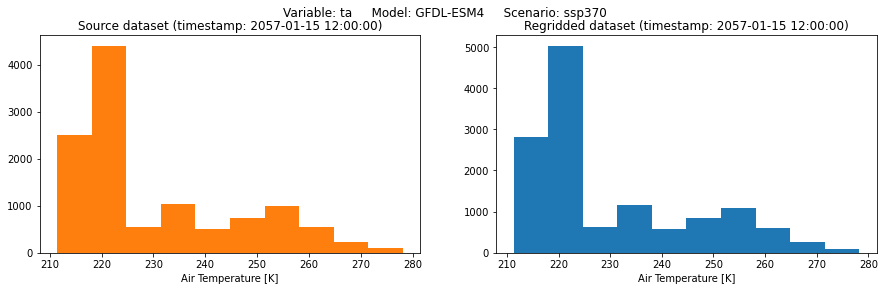

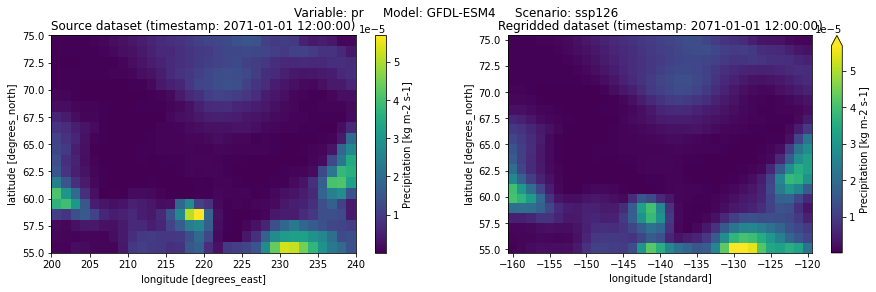

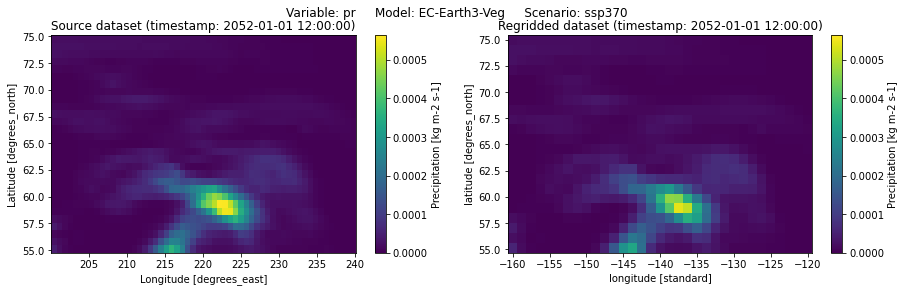

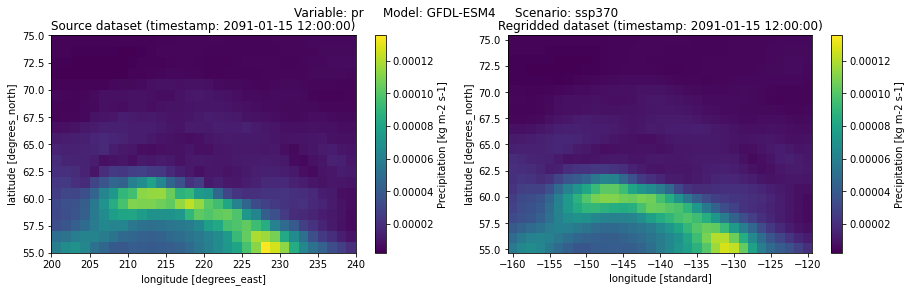

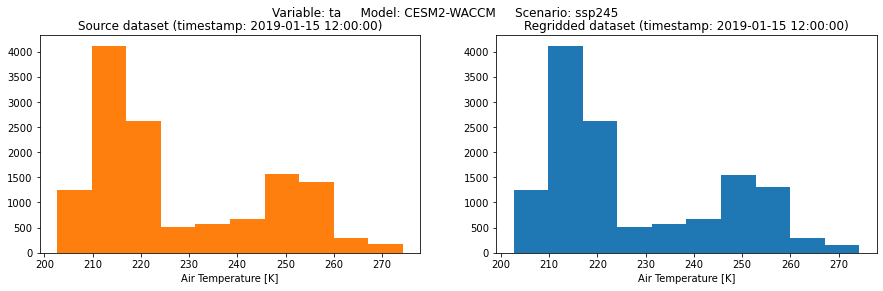

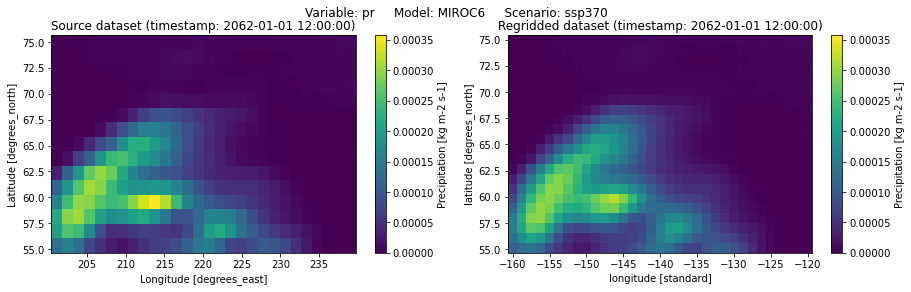

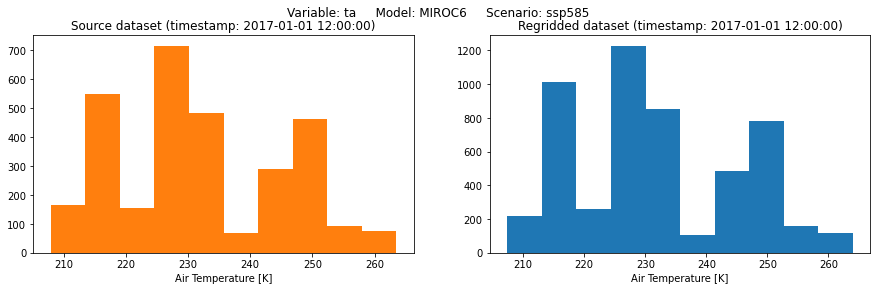

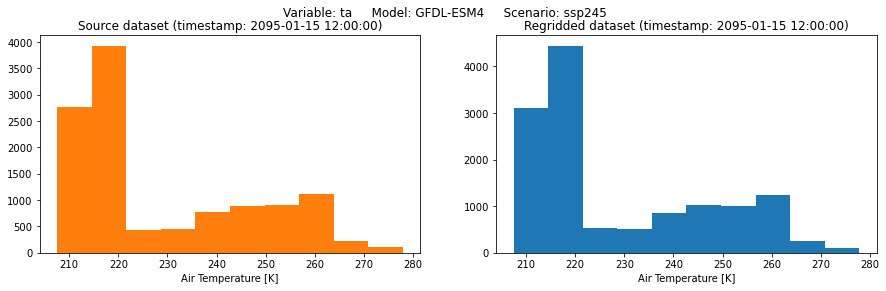

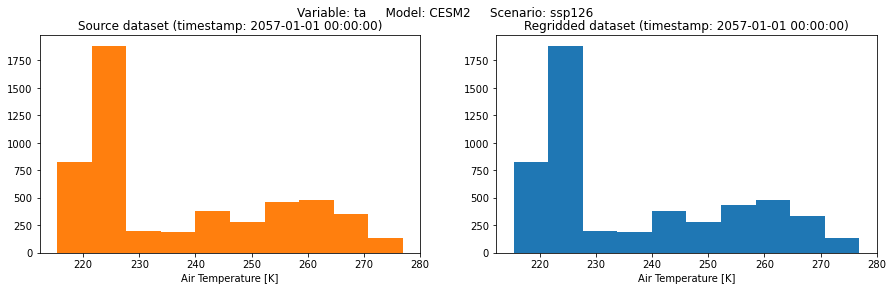

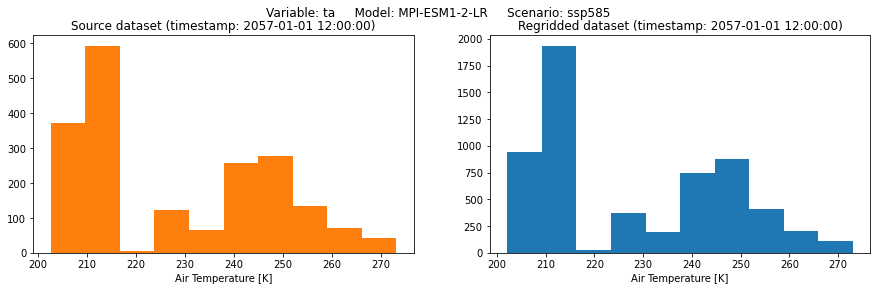

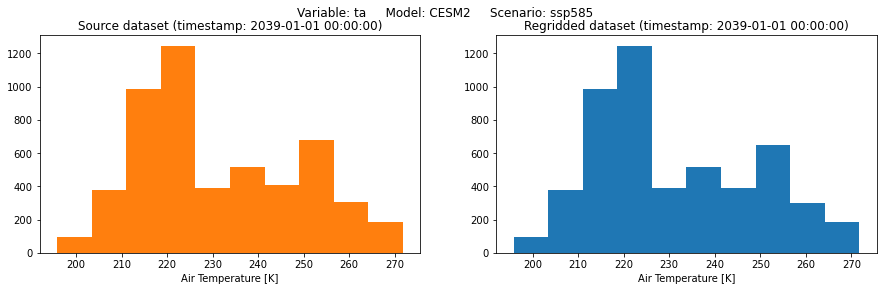

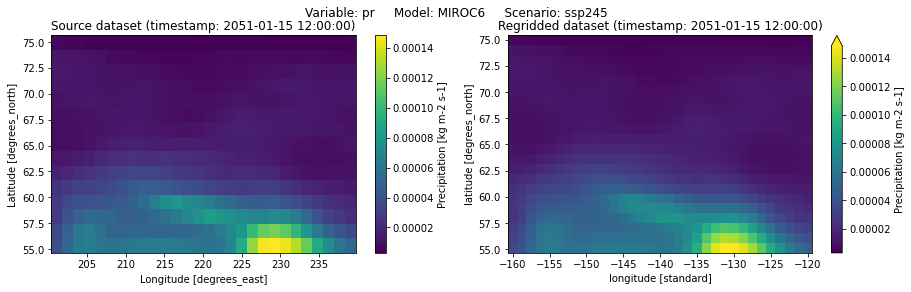

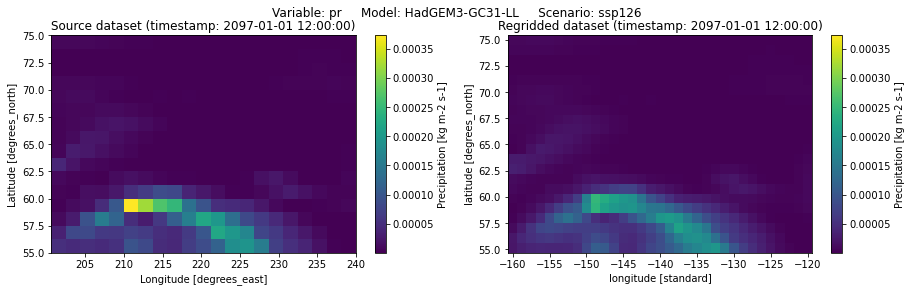

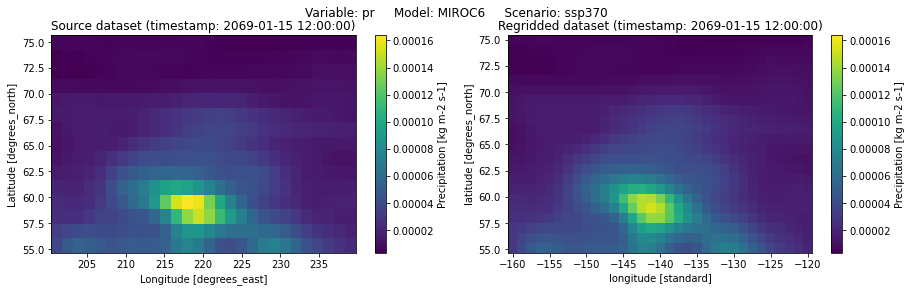

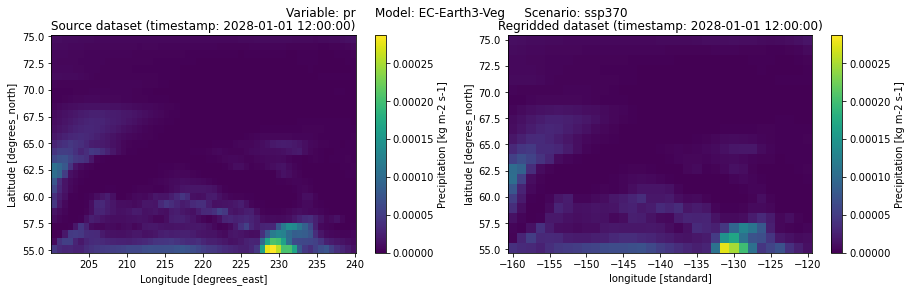

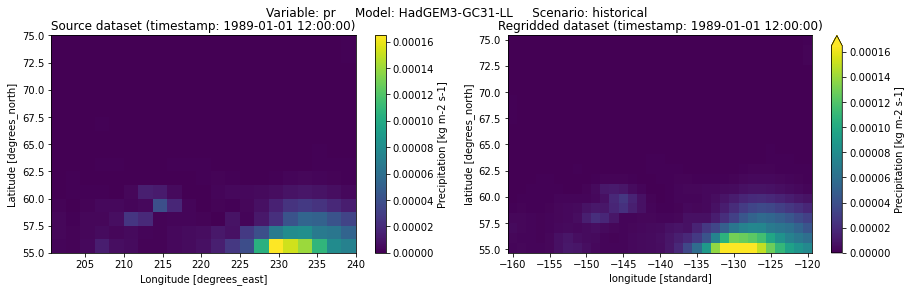

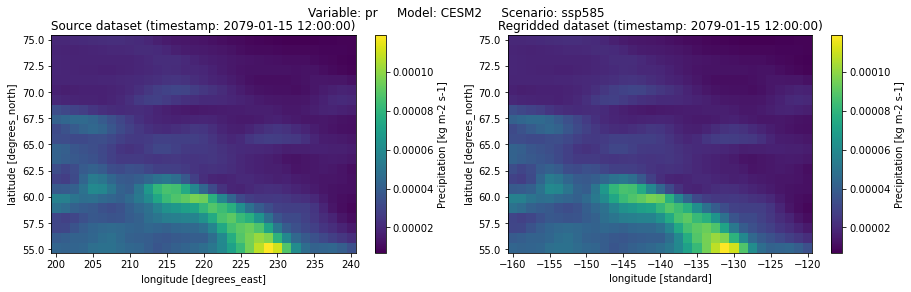

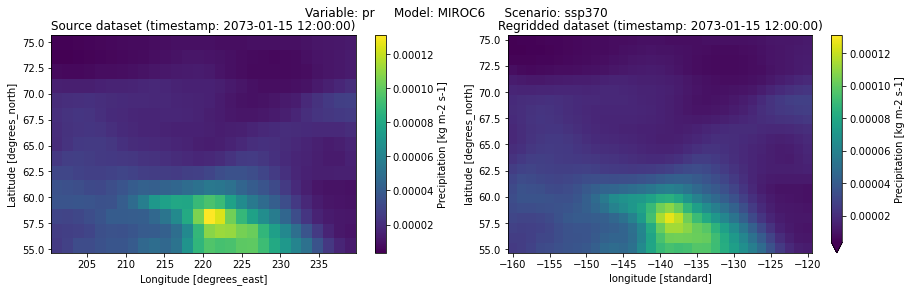

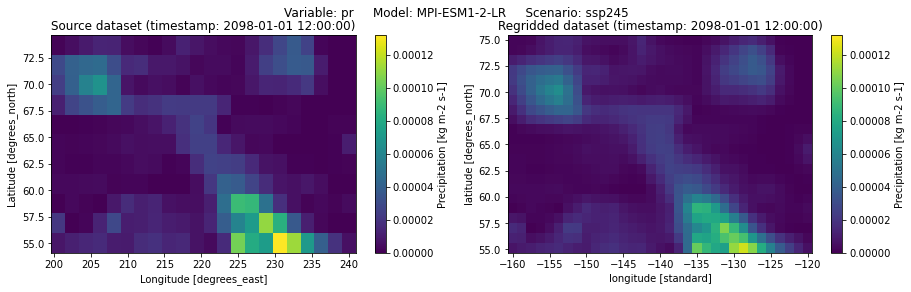

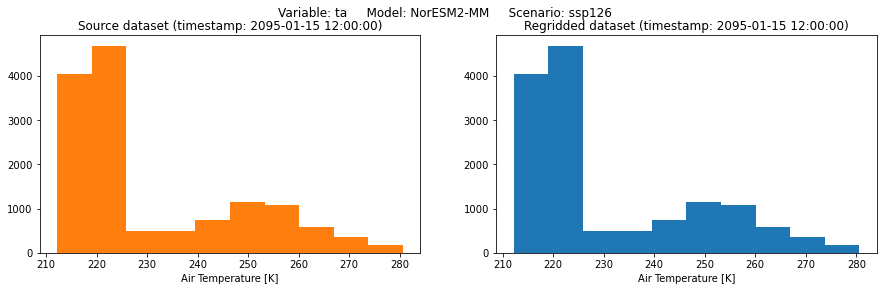

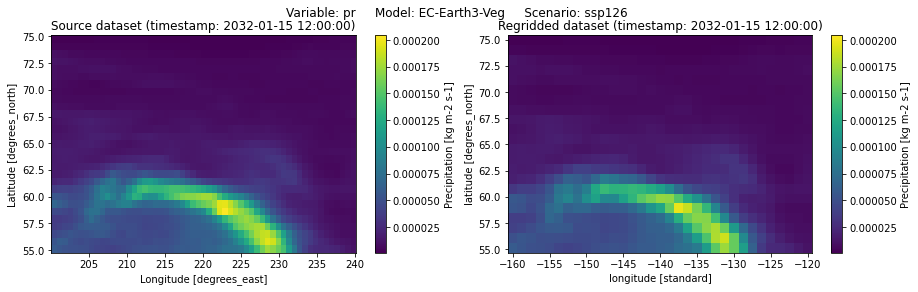

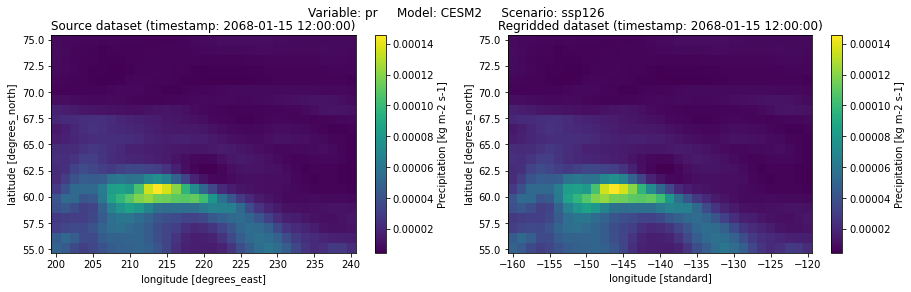

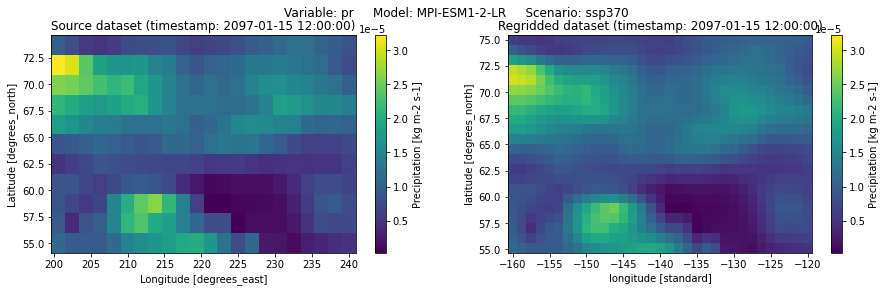

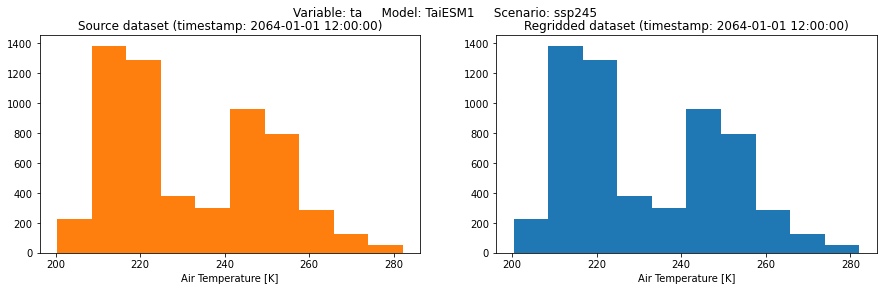

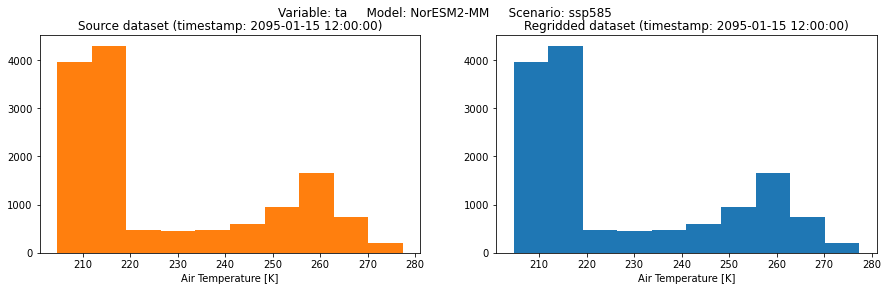

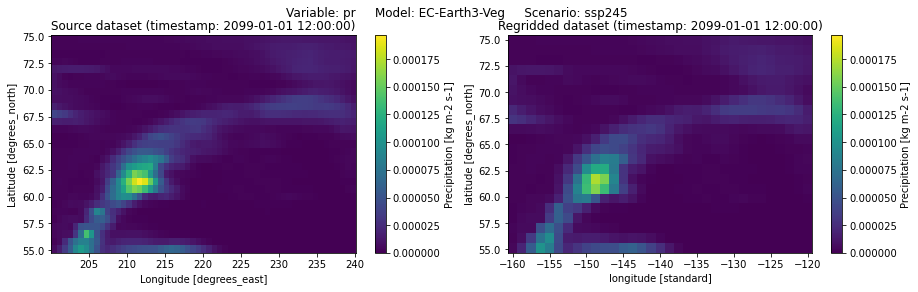

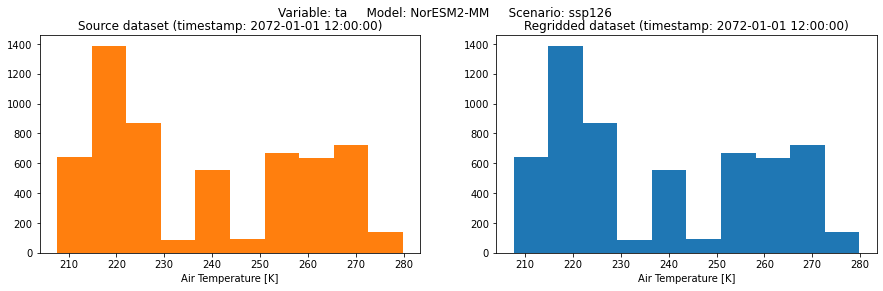

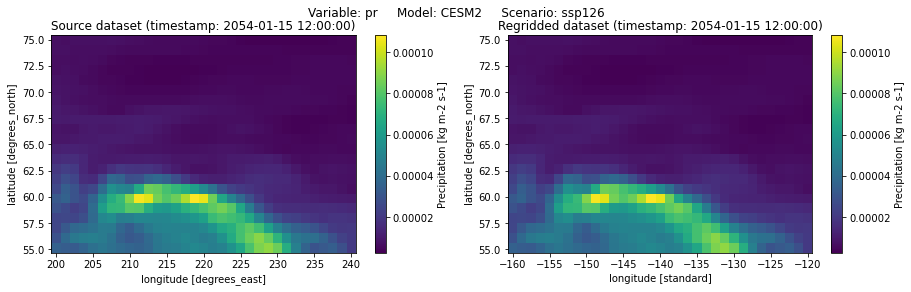

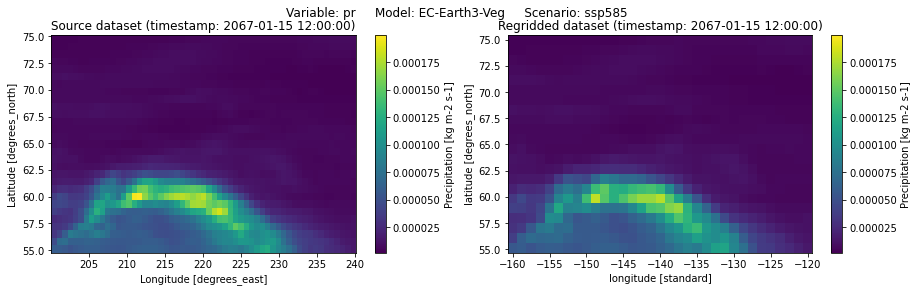

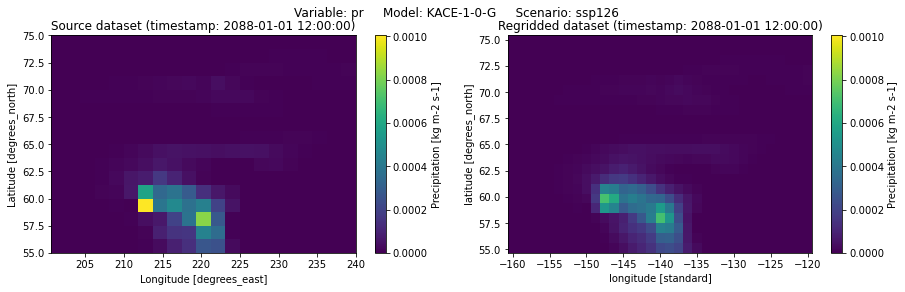

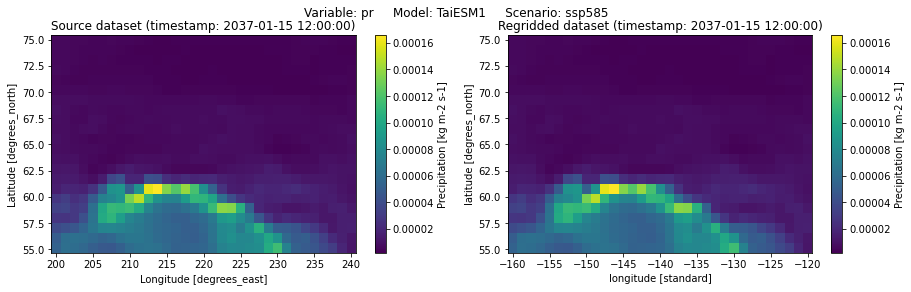

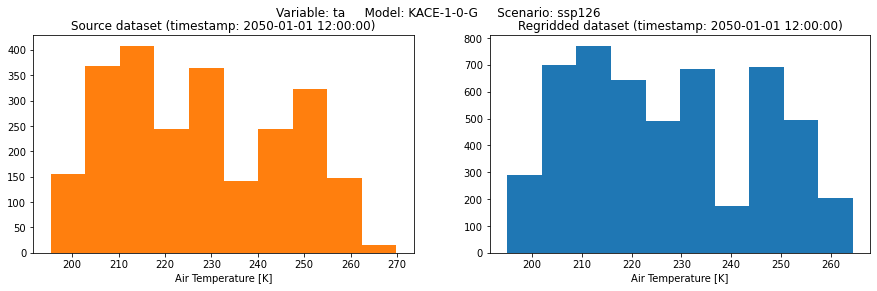

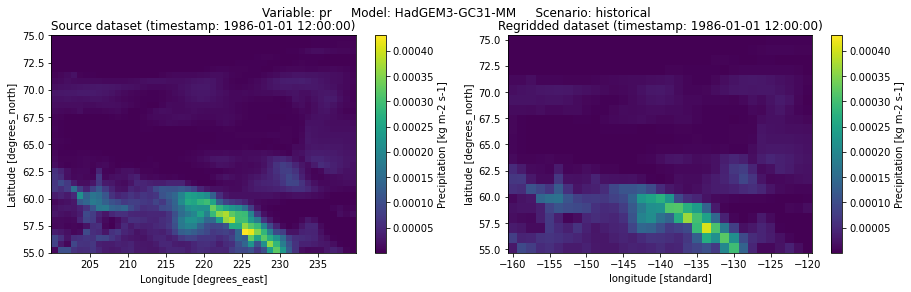

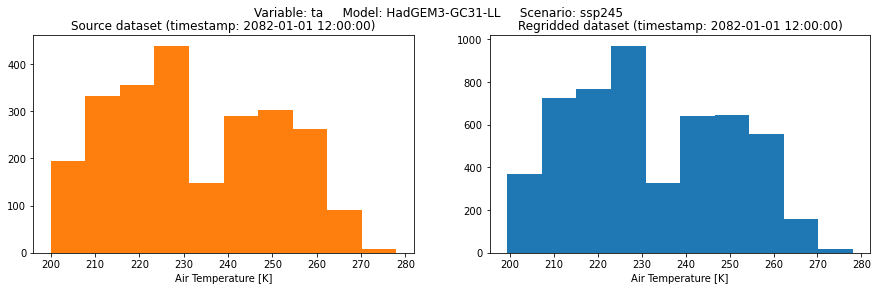

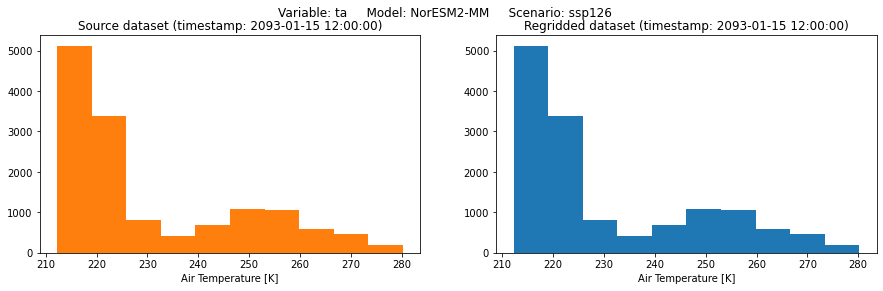

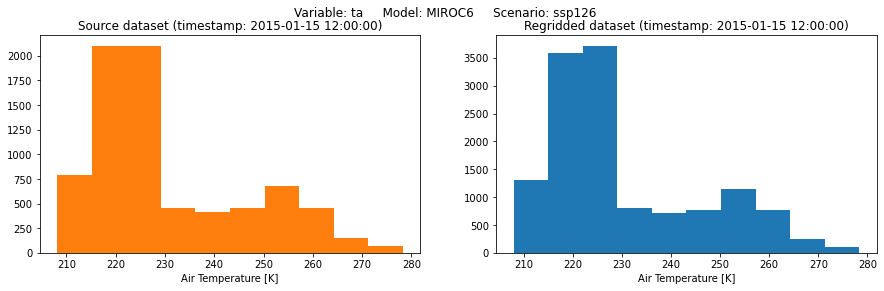

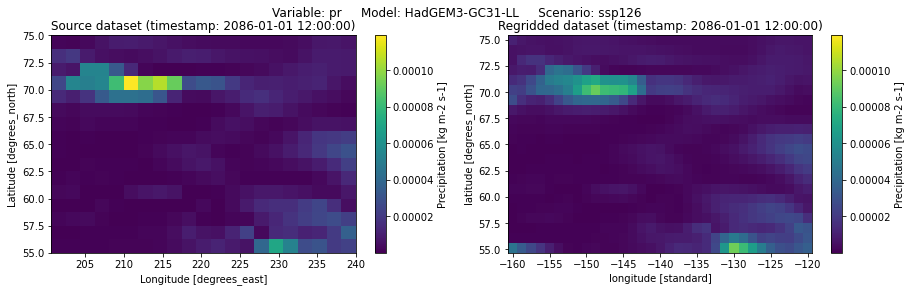

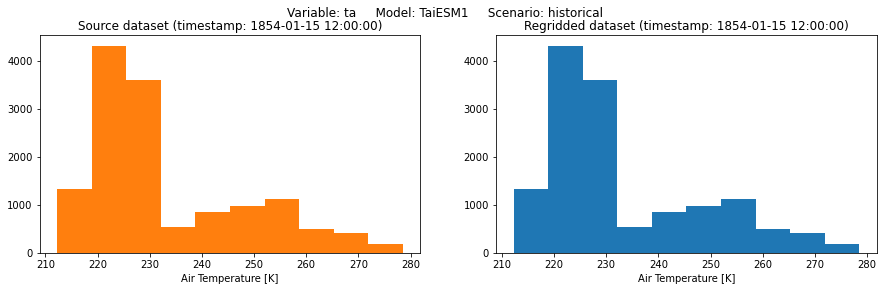

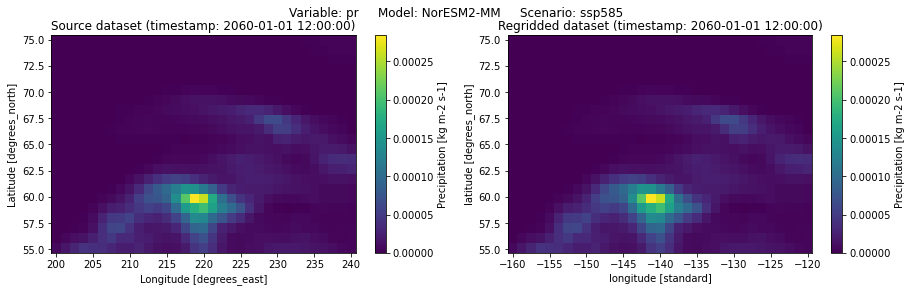

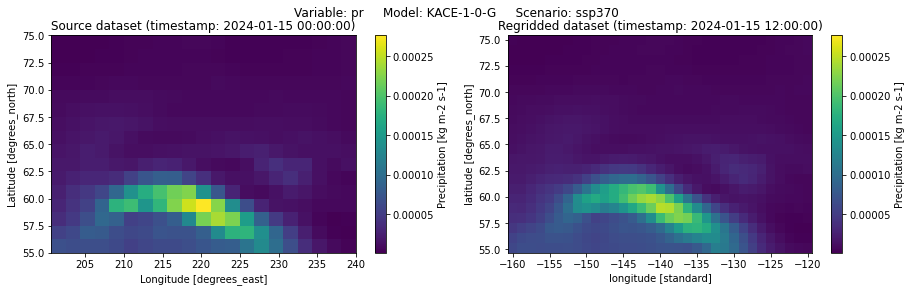

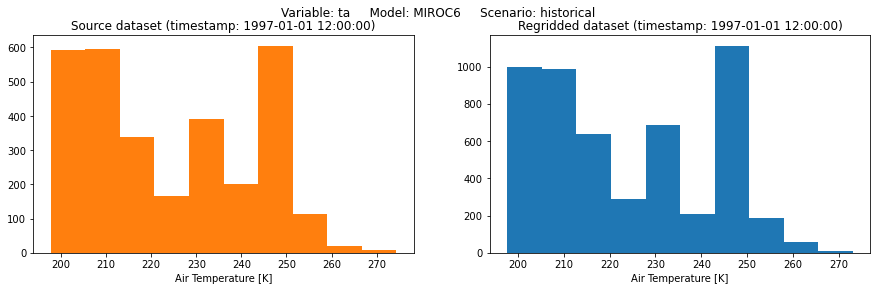

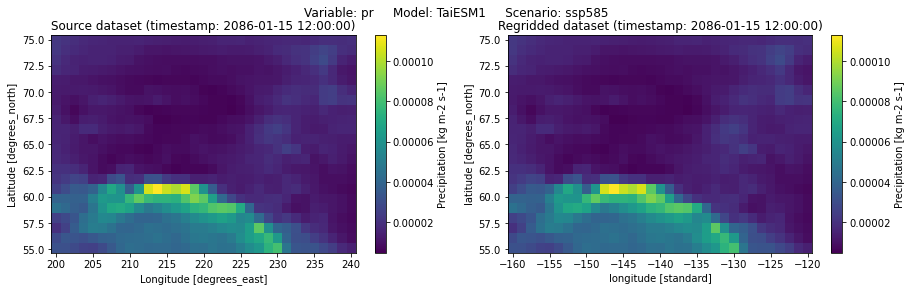

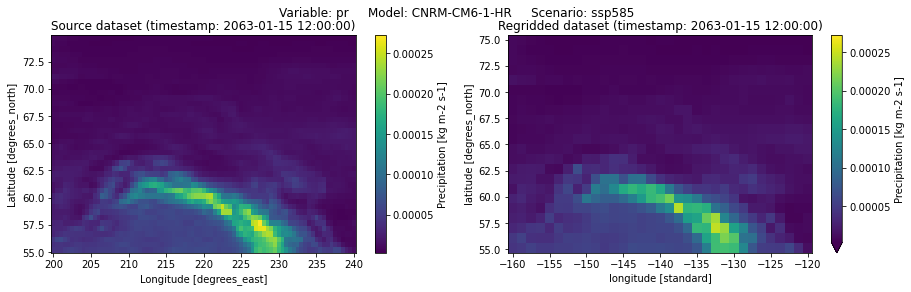

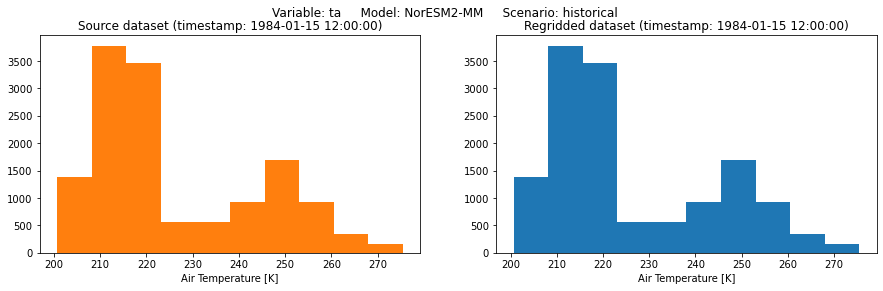

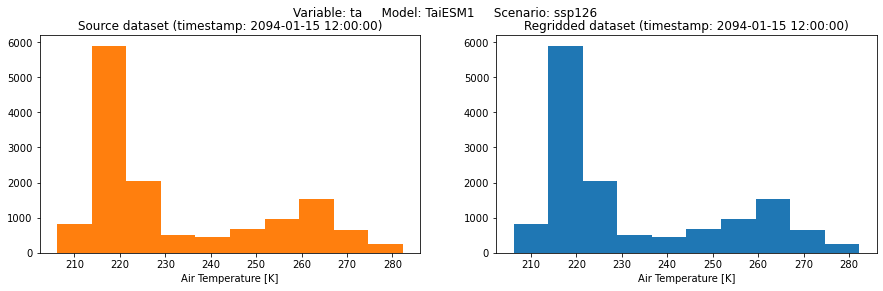

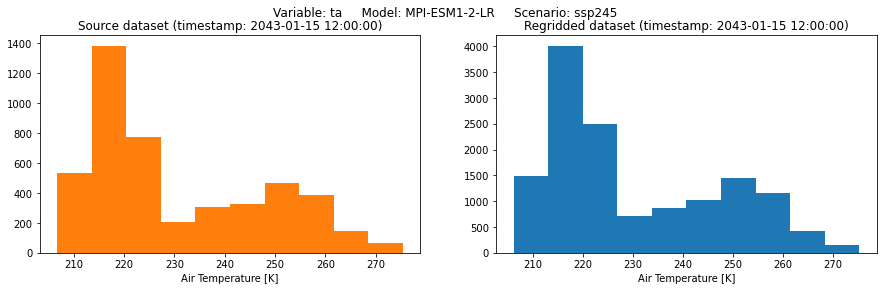

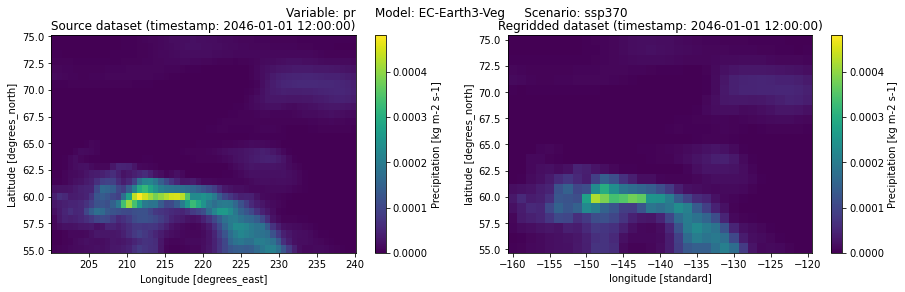

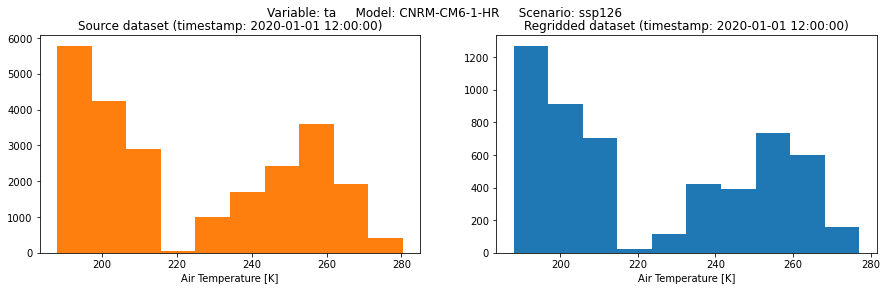

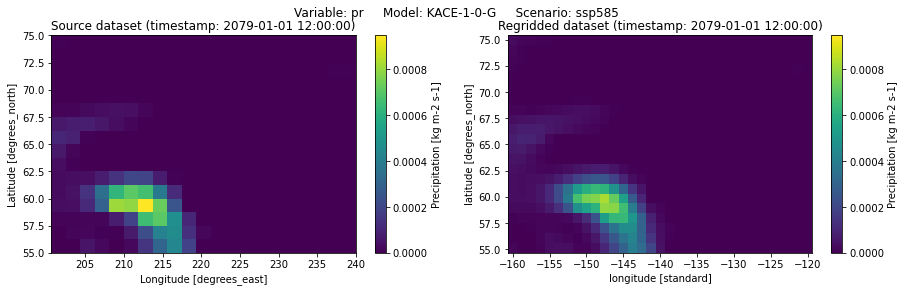

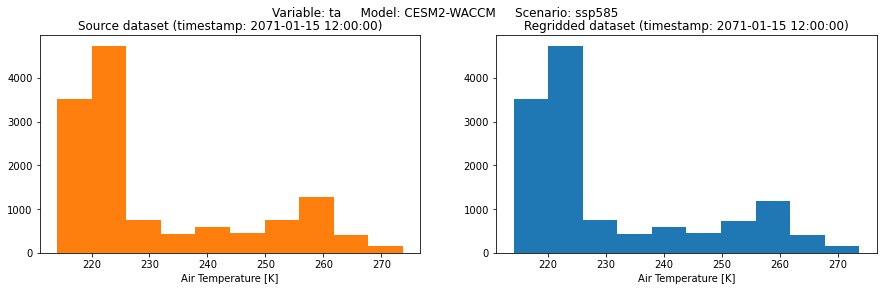

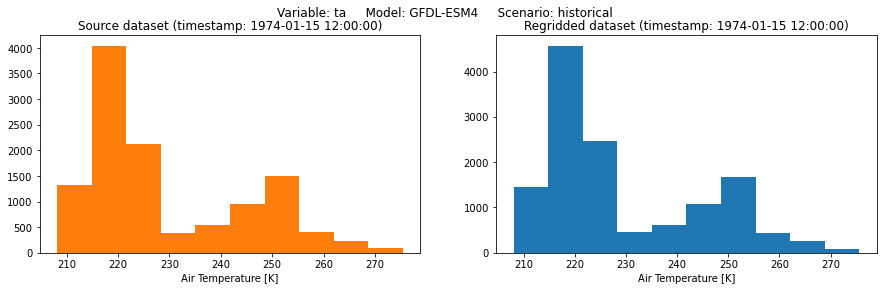

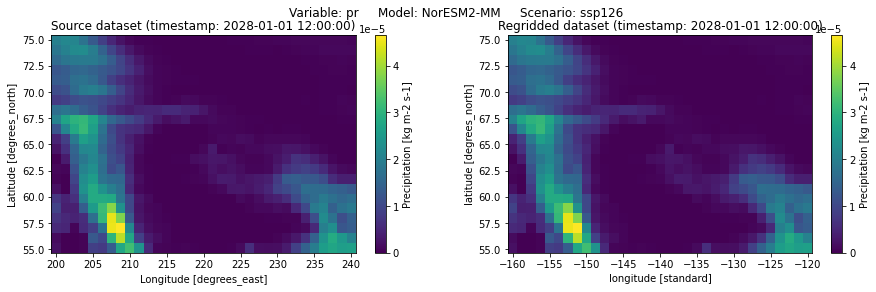

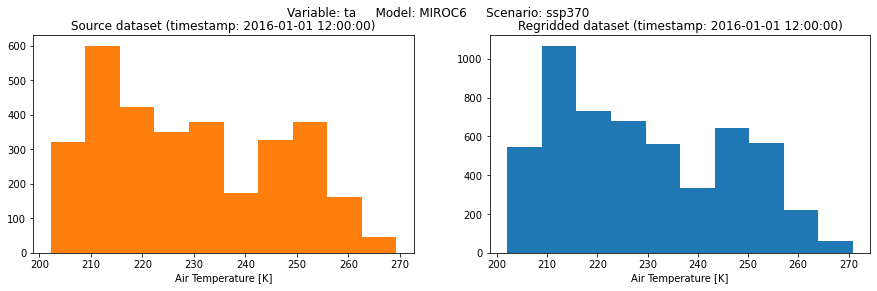

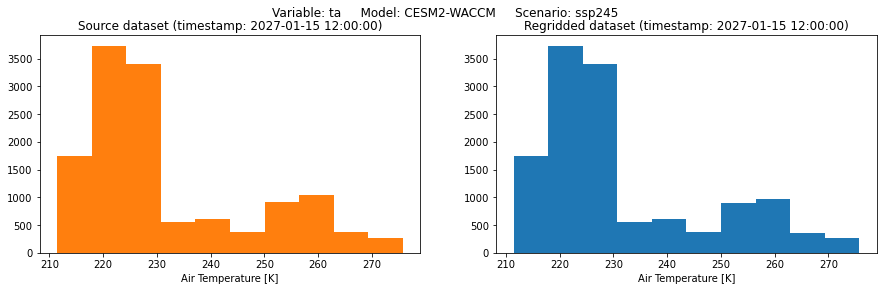

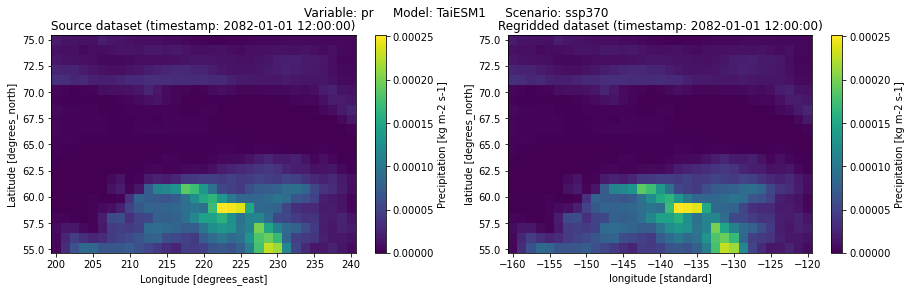

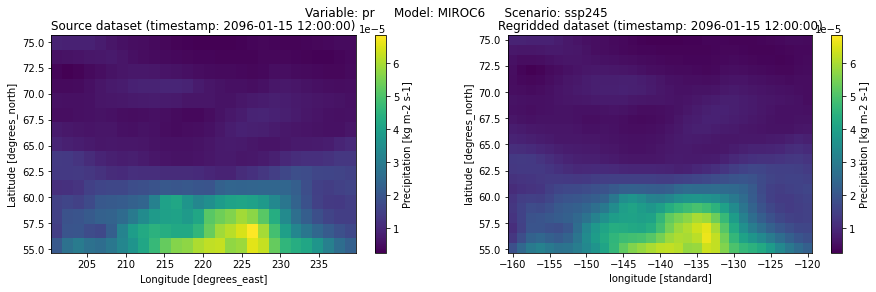

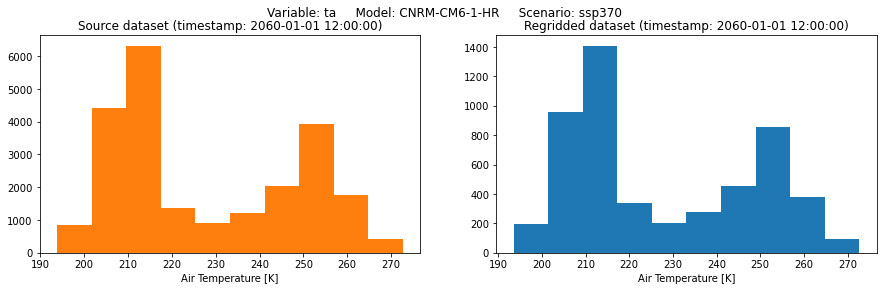

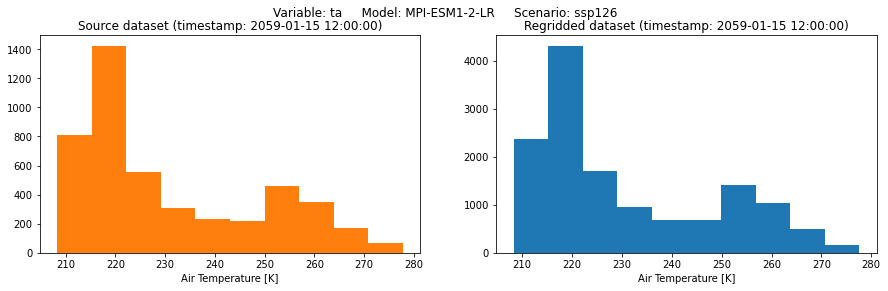

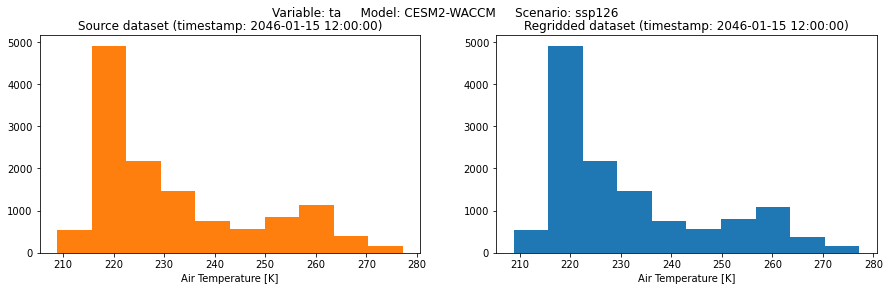

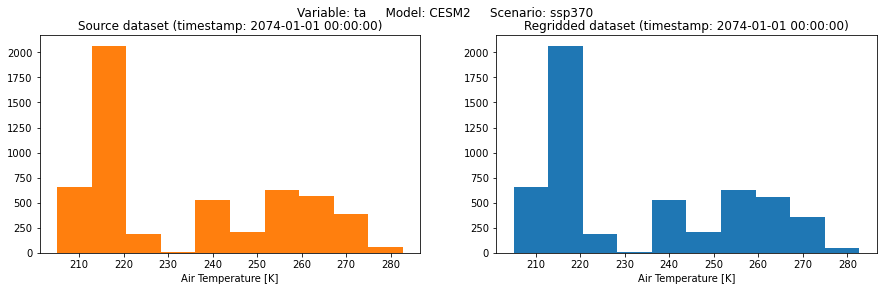

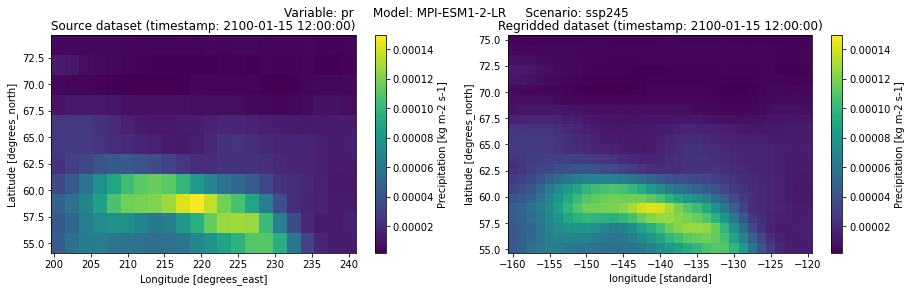

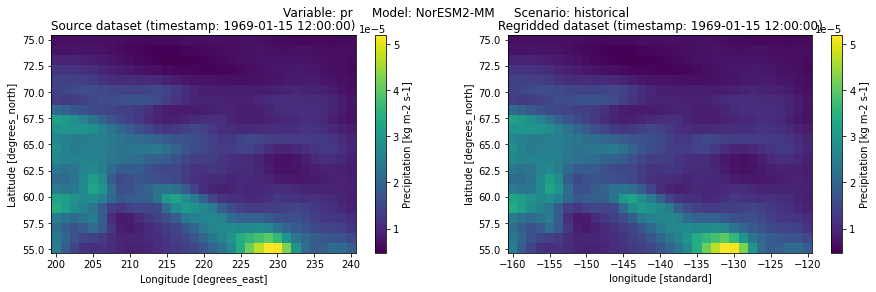

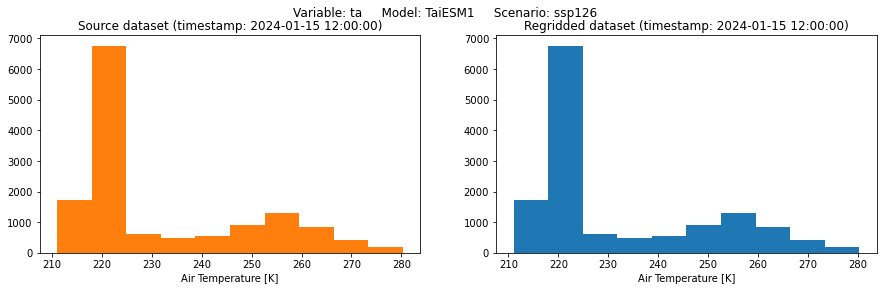

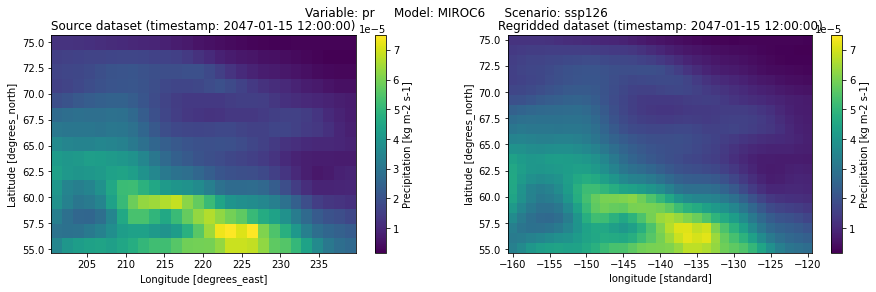

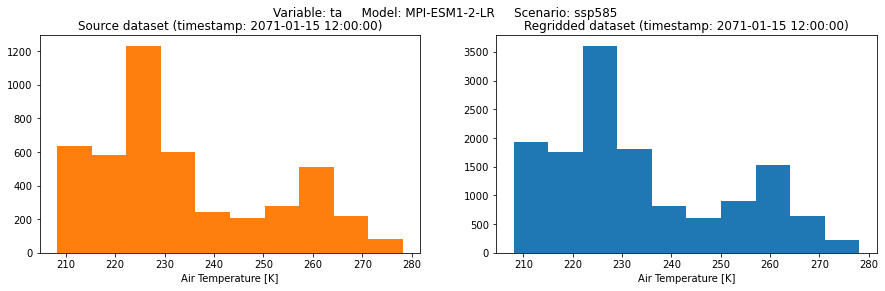

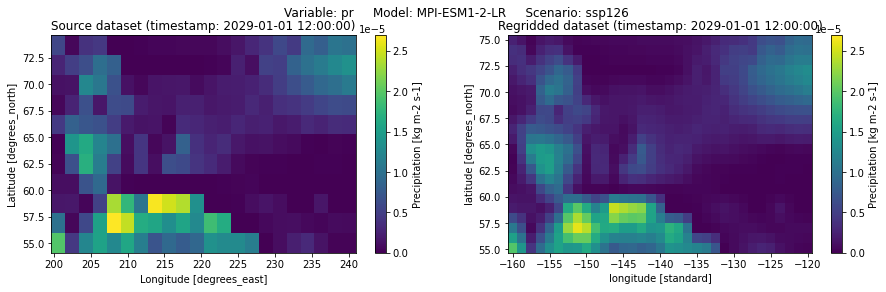

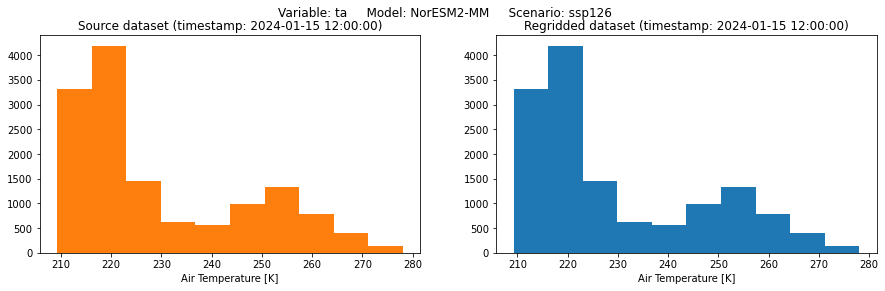

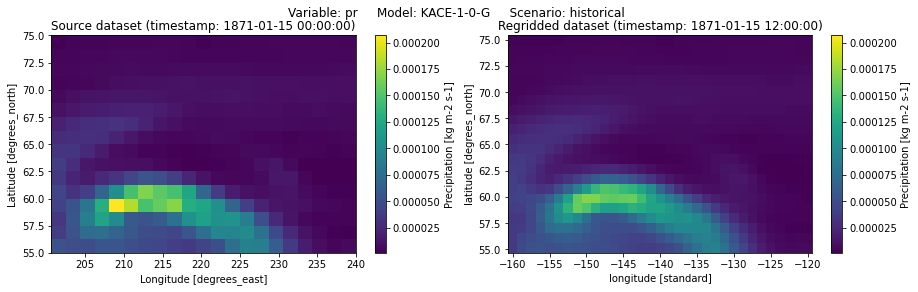

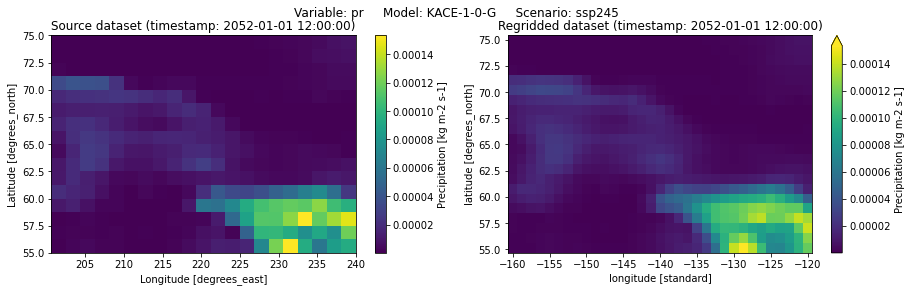

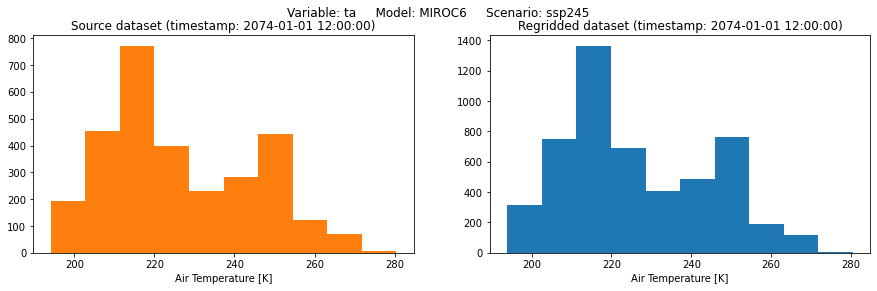

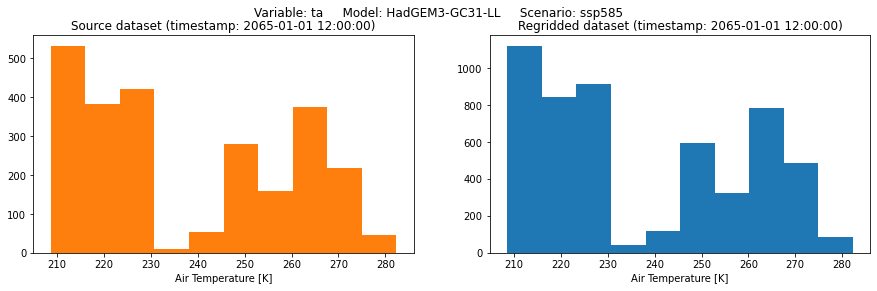

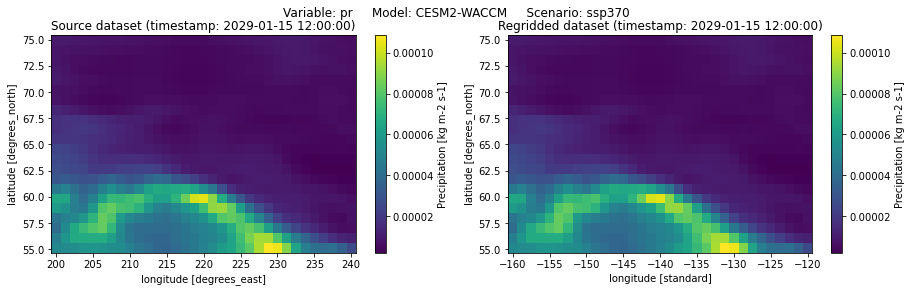

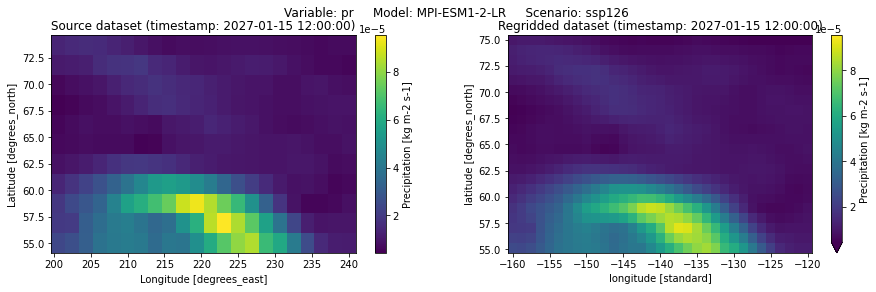

In [5]:
for fp in qc_files:
    plot_comparison(fp)